In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib import rcParams
from statannotations.Annotator import Annotator
import matplotlib.patches as mpatches
from scipy import stats
rcParams.update({'figure.autolayout': True})

In [136]:
#function to read in csv file as pandas df
def read_csv(file_name):
    df = pd.read_csv(file_name)
    #keep the Well, Sample, Target, Cq and Amp Status columns
    df = df[['Well', 'Sample', 'Target', 'Cq', 'Amp Status']]
    
    return df

In [137]:
# #returns test statistic, p-value
# for name1 in prom_names_plate1:
#     for name in names_plate1:
#         print(name1,'{}: {}'.format(name, stats.shapiro(luminescence_raw_df_plate1['nluc/fluc'][luminescence_raw_df_plate1.TF_added == name])))

In [138]:
#test for normality of the data
def test_normality(df, location):
    """run Shapiro-Wilk test"""
    #iterate over rows
    #get sample names
    sample_names = df['Sample'].unique()
    #get Target names
    target_names = df['Target'].unique()
    #iterate over samples and targets
    #make empty df to store p-values
    p_values = pd.DataFrame(columns=['Sample', 'Target', 'pvalue'])
    for sample in sample_names:
        for target in target_names:
            # #run Shapiro-Wilk test
           # print(sample,'{}: {}'.format(target, stats.shapiro(df['relative_expression'][df.Target == target])))
            #write a df with the results of the Shapiro-Wilk test
            #shapiro_df = pd.DataFrame(columns=['Sample', 'Target', 'p-value'])
            #results = sample,target,'{}'.format(stats.shapiro(df['relative_expression'][df.Target == target]))
            results = sample,target,stats.shapiro(df['relative_expression'][df.Target == target])
            #('125-4', 'NLP7: ShapiroResult(statistic=0.707939088344574, pvalue=9.890874935081229e-05)')
            shapiro_df = pd.DataFrame([results], columns=['Sample','Target', 'shapiro_test']).reset_index(drop=True)
            #get statistic and pvalue
            shapiro_df['statistic'] = shapiro_df['shapiro_test'].apply(lambda x: x[0])
            shapiro_df['pvalue'] = shapiro_df['shapiro_test'].apply(lambda x: x[1])
            #filter columns
            shapiro_df = shapiro_df[['Sample', 'Target', 'pvalue', 'statistic',]]
            #append to p_values df
            p_values = pd.concat([p_values, shapiro_df], axis=0, ignore_index=True)

    #write to tsv
    p_values.to_csv(f'{location}/shapiro_normality.tsv', sep='\t', index=False)

    return p_values





            


In [139]:
#function to filter out certain data points
def filter_data(df, amp_status, cq):
    #filter out the data points with amp_status = Amp using .loc
    df = df.loc[df['Amp Status'] == amp_status]
    #make Cq column numerical
    dfcopy = df.copy()
    dfcopy['Cq'] = pd.to_numeric(dfcopy['Cq'])  
    #filter out the data points with cq < cq_threshold using .loc
    dfcopy = dfcopy.loc[dfcopy['Cq'] <= cq]

    return dfcopy

In [140]:
#idea from https://www.nature.com/articles/s41598-021-99727-6#Sec2
#To detect outliers, the CT standard deviation (Cq-SD) of the technical replicates for a given sample is calculated, if the Cq-SD is greater than the cut-off (the default value is 0.3), then the technical replicate furthest from the sample mean is removed. The process occurs recursively until the Cq-SD is less than the cut-off or the value of “max outliers” is reached. This is determined by the parameter ‘Max Proportion’, the 0.5 default means that outliers will be removed until two technical replicates remain. The ‘preserve highly variable replicates’: If the Cq-SD is higher than 0.3, but the absolute (mean-median)/median is less than 0.1, replicates are preserved. This helps to account for a lack of a clear outlier, where two of three replicates are close to equally distributed around the mean.
def remove_outliers(df, max_outliers, ct_sd_threshold):
    
    #copy the dataframe
    dfcopy = df.copy()
    # Add filter columns
    dfcopy['Ignore'] = False
    #dfcopy['Cq-SD'] = int()
    
    #make Cq column numerical
    dfcopy['Cq'] = pd.to_numeric(dfcopy['Cq'])
    #calculate the Cq-SD of the technical replicates for a given sample
    f = (dfcopy['Ignore'].eq(False))
    dfcopy1 = dfcopy[f].groupby(['Sample','Target']).agg({'Cq':['std']})
    #dfcopy = dfcopy[f].groupby(['Sample','Target']).agg({'Cq-SD':['std']})#['Cq'].transform(lambda x: x.std() / np.sqrt(x.count()))
    #make df containing all samples with outliers
    f = dfcopy1['Cq']['std'] > ct_sd_threshold
    dfcopy_outliers = dfcopy1[f]

    
    # dfcopy_outliers = dfcopy[dfcopy['Cq-SD'] > ct_sd_threshold]
    if not dfcopy_outliers.empty:
        #mark all outliers
        #iterate over rows as tuples (sample, target)
        for i, row in enumerate(dfcopy_outliers.itertuples(name = None),1):
            #example row: (('144-5AH', 'DREB26'), 0.6497278066418295)
         
           
            #check that the dfcopy sample name is the same as the sample name in the current row
            f = (dfcopy.Sample == row[0][0]) & (dfcopy.Target == row[0][1]) & (dfcopy['Ignore'].eq(False))
            dx_idx = dfcopy[f].index
            group_size = len(dx_idx)
            min_size = round(group_size * (1-max_outliers))
            size = group_size
            if min_size < 2:
                min_size = 2
                print('Warning: minimum size of technical replicate group is 2')
            while True:
                f = (dfcopy.Sample == row[0][0]) & (dfcopy.Target == row[0][1])
                dx = dfcopy[f].copy()
                dxg = dfcopy[f].groupby(['Sample', 'Target']).agg({'Cq': [np.size, 'std', 'mean']})
                if dxg['Cq']['std'].iloc[0] <= ct_sd_threshold:
                    #Cq std is under threshold, so no outliers
                    break
                size -= 1
                if size < min_size:
                    #not enough technical replicates to remove outliers
                    break
                #remove the technical replicate furthest from the mean
                dx['Distance'] = (dx['Cq'] - dxg['Cq']['mean'].iloc[0])**2
                dx_sorted = dx.sort_values(by = 'Distance', ascending=False).index[0]
                #print()
                #dfcopy = dfcopy.loc[dx_sorted].assign(Ignore=True)
                #dfcopy.loc[dx_sorted].loc(:, 'Ignore') = True
                #print(dx_sorted)
                dfcopy.loc[[dx_sorted], 'Ignore'] = True
                #dfcopy['Ignore'].loc[dx_sorted] = True
                #rint(dx_sorted)
                
    return dfcopy


            


   
    # #remove the highly variable replicates
    # if preserve_highly_variable_replicates == True:
    #     dfcopy = dfcopy.loc[dfcopy['Cq-SD'] > ct_sd_threshold]
    #     dfcopy = dfcopy.loc[dfcopy['Cq-SD'] < (dfcopy['Cq-SD'].mean() - dfcopy['Cq-SD'].median())/dfcopy['Cq-SD'].median()]
    # #remove the outliers until the number of outliers is less than max_outliers
    # while dfcopy['Cq-SD'].count() > max_outliers:
    #     dfcopy = dfcopy.loc[dfcopy['Cq-SD'] < ct_sd_threshold]
    #     if preserve_highly_variable_replicates == True:
    #         dfcopy = dfcopy.loc[dfcopy['Cq-SD'] > ct_sd_threshold]
    #         dfcopy = dfcopy.loc[dfcopy['Cq-SD'] < (dfcopy['Cq-SD'].mean() - dfcopy['Cq-SD'].median())/dfcopy['Cq-SD'].median()]
    # return dfcopy

In [141]:
#function to make new columns and sort the data
def sort_data(df, location, name):
    #make new column called EF1a_Cq, make the value in this column for a particular sample equal to the Cq value for the EF1a Target for that sample
    ##remove if not amplified
    df = df.loc[df['Amp Status'] == 'Amp']
    

    #first remove outliers
    df = remove_outliers(df, 0.5, 0.3)
    #save outliers df to tsv
    df.to_csv(f'{location}/including_outliers_{name}.tsv', sep='\t', index=False)
    #remove outliers
    df = df.loc[df['Ignore'] == False]    
    #get the mean of each sample/target (take mean of technical replicates)
    df['Cq_mean'] = df.groupby(['Sample','Target'])['Cq'].transform('mean')
    #make a df containing only EF1a target (housekeeping gene)
    df_EF1a = df.loc[df['Target'] == 'EF1a'].copy()

    #rename the Cq_mean column to EF1a_Cq_mean
    df_EF1a.rename(columns={'Cq_mean': 'EF1a_Cq_mean'}, inplace=True)
    #filter other df_EF1a columns
    df_EF1a = df_EF1a[['Sample','EF1a_Cq_mean']]
    #remove duplicates from df_EF1a
    df_EF1a = df_EF1a.drop_duplicates()
    
    #merge the two dfs together
    df = pd.merge(df, df_EF1a, on=['Sample'], how='left')
    

    #normalise based on eEF1a gene
    df = normalise_data(df, 'Cq_mean','EF1a_Cq_mean','MeanCq_ECnormalised')
    #filter columns
    df = df[['Sample','Target','Cq_mean','MeanCq_ECnormalised']]
    #remove duplicates
    df = df.drop_duplicates()


    #normalise to sample 125-4AH on each plate (plate normalisation so can compare between plates)
    #get 125-4AH NIR1 10mM nitrate sample MeanCq_ECnormalised
    sample_125_4AH = df[(df.Sample == '125-4AH')&(df.Target == "NIR1")].MeanCq_ECnormalised.values[0]
    #print(f'{sample_125_4AH}')
    #normalise
    df.loc[:,'MeanCq_EC_plate_calibrated'] = df['MeanCq_ECnormalised'] - sample_125_4AH
    #remove nan values in the new column
    df = df[df['MeanCq_EC_plate_calibrated'].notna()]
    #add column with name
    df['plateID'] = name
   
   # print(df)
    #if Sample column ends with NRT, add NRT_Cq column
    df['NRT'] = False
    df.loc[df['Sample'].str.endswith('NRT'), 'NRT'] = True
    #remove NRT string from Sample columns ending with NRT
    df['Sample'] = df['Sample'].str.replace('NRT', '')
    
    
    #if Sample column ends with H, add condition column with 10mM_nitrate
    df['condition'] = np.nan
    df.loc[df['Sample'].str.endswith('H'), 'condition'] = '10mM_nitrate'
    #remove H string from Sample columns ending with H
    df['Sample'] = df['Sample'].str.replace('H', '')

    #if Sample column ends with L, add condition column with 1mM_nitrate
    df.loc[df['Sample'].str.endswith('L'), 'condition'] = '1mM_nitrate'
    #remove L string from Sample columns ending with L
    df['Sample'] = df['Sample'].str.replace('L', '')
    #remove A, B or C string from Sample columns ending with A, B or C
    df.loc[:, 'Sample_old'] = df['Sample']
    df['Sample'] = df['Sample'].str.replace('A', '')
    df['Sample'] = df['Sample'].str.replace('B', '')
    #remove C string from Sample columns ending with C after the dash
    df['Sample'] = df['Sample'].str.replace('C', '')
    #remove whitespace from Sample columns
    df['Sample'] = df['Sample'].str.strip()
    #if sample is "ol-0", rename to Col-0
    df.loc[df['Sample'] == 'ol-0', 'Sample'] = 'Col-0'
    
 
    #now make a df containing only Samples with 1mM_nitrate condition
    df_1mM_nitrate = df.loc[df['condition'] == '1mM_nitrate'].copy()

    #make new column that is the Mean expression across all biological replicates
    df_1mM_nitrate['Mean_biological_Cq_ECnormalised'] = df_1mM_nitrate.groupby(['Sample','Target', 'condition'])['MeanCq_EC_plate_calibrated'].transform('mean')


    #rename Mean_biological_Cq_ECnormalised column to 1mMnitrate_Cq_mean
    df_1mM_nitrate.rename(columns={'Mean_biological_Cq_ECnormalised': '1mMnitrate_Cq_mean'}, inplace=True)
    #filter other columns
    df_1mM_nitrate = df_1mM_nitrate[['Sample_old','Target','1mMnitrate_Cq_mean']]
    #remove duplicates from df_1mM_nitrate
    df_1mM_nitrate = df_1mM_nitrate.drop_duplicates()
    #merge the dfs
    df = pd.merge(df, df_1mM_nitrate, on=['Sample_old','Target'], how='left')


    

    #remove nan
    #df = df.dropna()

    #remove NRT values
    df = df.loc[df['NRT'] == False]


    return df


In [142]:
#function to normalise the data based on a column of Cq values (either to housekeeping or based on nitrate or wild type plant)
def normalise_data(df, orig_col,normalisation_col, new_column_name):
   
    #normalise Cq values to the EF1a housekeeping gene mean Cq value for each sample
    df.loc[:,new_column_name] = df[orig_col] - df[normalisation_col]
    #remove nan values in the new column
    df = df[df[new_column_name].notna()]


    return df

In [143]:
#make individual plots
def make_plots(df,location, normal,sample_order):
    """function to make barplots of relative expression of each target gene in each plant line"""
    #plot height and width
    height = 5
    width = 3.5

    #decide on stats test
    if normal is True:
        stats_test = 't-test_ind'
    if normal is False:
        stats_test = 't-test_welch'


    #make individual plots
     
    for target in df['Target'].unique():
        #if target is not EF1a, make plot
        if target != 'EF1a':            
            temp_df = df[df.Target == target]
            #change condition values
            temp_df.loc[temp_df['condition'] == '10mM_nitrate', 'condition'] = '10'
            temp_df.loc[temp_df['condition'] == '1mM_nitrate', 'condition'] = '1'


            #get list of samples
            samples_unique = temp_df['Sample'].unique()

            

            #sort based on custom order
            samples = []
            for i in range(len(sample_order)):
                if sample_order[i] in samples_unique:
                    samples+=[sample_order[i]]
            #create new df with only sample of interest and Col-0 based on plateID so that Col-0 from the same plate is prioritised
            #if temp_df plateID is "22.08.22_plate1"

            for sample in samples:
                if sample != 'Col-0':
                    plateID_value = temp_df.loc[temp_df['Sample'] == sample, 'plateID'].values[0]
                   # print(plateID_value)
                    if plateID_value == '22.08.22_plate1':   
                        #print(f'platevalueis{plateID_value}')                
                        df_new = temp_df[(temp_df.Sample == sample) | ((temp_df.Sample == 'Col-0') & (temp_df.plateID == plateID_value))]

                    if plateID_value == '22.08.22_plate2':

                        df_new = temp_df[(temp_df.Sample == sample) | ((temp_df.Sample == 'Col-0') & (temp_df.plateID == plateID_value))]
                    if plateID_value == '10.8.22':
                        #include all col-0 values from both plates       
                        df_new = temp_df[(temp_df.Sample == sample) | (temp_df.Sample == 'Col-0')]
                    #create box pairs
                    pairs = [(('Col-0','1'),(sample,'1')),(('Col-0','10'),(sample,'10'))]

                    order = ['Col-0',sample]


                    #make figure





            # #get length of number of samples
            # length_samples = len(samples)

            # #create order and box pairs based on the length of TFs
            # order = []
            # box_pairs = []
            # for x in range (0, (length_samples)):
            #     order.append(samples[x])
            #     # if 'Col-0' in samples:
            #     #     if samples[x] != 'Col-0':
            #     #         box_pairs.append(('col-0', samples[x]))
            #     # if 'ol-0' not in samples:
            #     box_pairs.append(((samples[x],'1'), (samples[x],'10')))


            

            # order = ['1','10']
            # #create box pairs
            # pair = [('1', '10')]

                    #make plot
                    fig_args = {'x':'Sample', 'y':'relative_expression','hue':'condition', 'hue_order':['1','10'],'data':df_new, 'order':order, 'dodge':True}

                    configuration = {'test':stats_test, 'text_format':'star', 'pvalue_thresholds':[[1e-3, "***"],[1e-2, "**"],[0.05, "*"],[1, "ns"]]}

                    _ = plt.figure(figsize=(width,height))

                    fig = sns.barplot(**fig_args, palette=["lightcyan", "cyan"],linewidth=2,  errcolor="black", edgecolor="black", ci=68, errwidth=1,capsize=0.4)
                    fig = sns.swarmplot(**fig_args, color='black')
                    
                    #fig = sns.barplot(x='Sample', y='relative_expression', data=temp_df, order=order, linewidth=2,  errcolor="black", edgecolor="black", ci=68, errwidth=1,capsize=0.4,color='cyan')

                    #fig = sns.swarmplot(x='condition', y='relative_expression', data=temp_df, order=order,color='black')

                    #add stats
                    annotator = Annotator(fig, pairs, **fig_args,verbose=False)
                    annotator.configure(**configuration)
                    # annotator = Annotator(fig, pairs, data=temp_df, x='condition', y='relative_expression',order=order,verbose=False)
                    # annotator.configure(test=stats_test, text_format='star',pvalue_thresholds=[[1e-3, "***"],[1e-2, "**"],[0.05, "*"],[1, "ns"]])
                    
                    #save stats to file
                    ax, test_results = annotator.apply_and_annotate()
                    with open(f'{location}/individual/stats.txt', 'a') as f:                            
                        for res in test_results:
                            f.write(f'{str(sample)},{target},{pairs},{str(res.data)}\n')
                    
                    # change axes labels
                    _ = plt.ylabel('Relative expression (a.u.)')
                    
                    
                    #add plot title
                    _ = plt.title(f'{target}')

                    #rename x axis labels
                    #_ = plt.set_xticklabels( ('1','10') )
                    #change x axis name
                    _ = plt.xlabel('Plant line')
            
                    #make xticks diagonal
                    # _ = plt.xticks(rotation=90, ha='center')

                    #plot legend, excluding legend from swarm plot
                    h,l = fig.get_legend_handles_labels()
                    #change name of label
                    l[3] = "10 mM nitrate"
                    #l[2] = "20 mM KNO\u2083 + 20 mM NH\u2083NO\u2083"   
                    l[2] = "1 mM nitrate"     
                    plt.legend(h[2:4],l[2:4],fontsize=10,frameon=False)#,bbox_to_anchor=(0,0.85), loc='best',



                    #save plot to file
                    plt.savefig(
                                    f'{location}/individual/{sample}_{target}_col0.pdf',
                                    format="pdf",
                                    bbox_inches="tight",transparent=True)
                    plt.savefig(
                                    f'{location}/individual/{sample}_{target}_col0.svg',
                                    format="svg",
                                    bbox_inches="tight",transparent=True)
                    plt.close()






In [144]:
#make individual plots to compare nitrate
def make_plots_nitrate(df,location, normal,sample_order):
    """function to make barplots of relative expression of each target gene in each plant line"""
    #plot height and width
    height = 5
    width = 3.5

    #decide on stats test
    if normal is True:
        stats_test = 't-test_ind'
    if normal is False:
        stats_test = 't-test_welch'


    #make individual plots
     
    for target in df['Target'].unique():
        #if target is not EF1a, make plot
        if target != 'EF1a':            
            temp_df = df[df.Target == target]
            #change condition values
            temp_df.loc[temp_df['condition'] == '10mM_nitrate', 'condition'] = '10'
            temp_df.loc[temp_df['condition'] == '1mM_nitrate', 'condition'] = '1'


            #get list of samples
            samples_unique = temp_df['Sample'].unique()

            

            #sort based on custom order
            samples = []
            for i in range(len(sample_order)):
                if sample_order[i] in samples_unique:
                    samples+=[sample_order[i]]
            #create new df with only sample of interest and Col-0 based on plateID so that Col-0 from the same plate is prioritised
            #if temp_df plateID is "22.08.22_plate1"

            for sample in samples:
                if sample != 'Col-0':
                    plateID_value = temp_df.loc[temp_df['Sample'] == sample, 'plateID'].values[0]
                   # print(plateID_value)
                    if plateID_value == '22.08.22_plate1':   
                        #print(f'platevalueis{plateID_value}')                
                        df_new = temp_df[(temp_df.Sample == sample) | ((temp_df.Sample == 'Col-0') & (temp_df.plateID == plateID_value))]

                    if plateID_value == '22.08.22_plate2':

                        df_new = temp_df[(temp_df.Sample == sample) | ((temp_df.Sample == 'Col-0') & (temp_df.plateID == plateID_value))]
                    if plateID_value == '10.8.22':
                        #include all col-0 values from both plates       
                        df_new = temp_df[(temp_df.Sample == sample) | (temp_df.Sample == 'Col-0')]
                    #create box pairs
                    pairs = [(('Col-0','1'),('Col-0','10')),((sample,'1'),(sample,'10'))]

                    order = ['Col-0',sample]


                    #make figure





            # #get length of number of samples
            # length_samples = len(samples)

            # #create order and box pairs based on the length of TFs
            # order = []
            # box_pairs = []
            # for x in range (0, (length_samples)):
            #     order.append(samples[x])
            #     # if 'Col-0' in samples:
            #     #     if samples[x] != 'Col-0':
            #     #         box_pairs.append(('col-0', samples[x]))
            #     # if 'ol-0' not in samples:
            #     box_pairs.append(((samples[x],'1'), (samples[x],'10')))


            

            # order = ['1','10']
            # #create box pairs
            # pair = [('1', '10')]

                    #make plot
                    fig_args = {'x':'Sample', 'y':'relative_expression','hue':'condition', 'hue_order':['1','10'],'data':df_new, 'order':order, 'dodge':True}

                    configuration = {'test':stats_test, 'text_format':'star', 'pvalue_thresholds':[[1e-3, "***"],[1e-2, "**"],[0.05, "*"],[1, "ns"]]}

                    _ = plt.figure(figsize=(width,height))

                    fig = sns.barplot(**fig_args, palette=["lightcyan", "cyan"],linewidth=2,  errcolor="black", edgecolor="black", ci=68, errwidth=1,capsize=0.4)
                    fig = sns.swarmplot(**fig_args, color='black')
                    
                    #fig = sns.barplot(x='Sample', y='relative_expression', data=temp_df, order=order, linewidth=2,  errcolor="black", edgecolor="black", ci=68, errwidth=1,capsize=0.4,color='cyan')

                    #fig = sns.swarmplot(x='condition', y='relative_expression', data=temp_df, order=order,color='black')

                    #add stats
                    annotator = Annotator(fig, pairs, **fig_args,verbose=False)
                    annotator.configure(**configuration)
                    # annotator = Annotator(fig, pairs, data=temp_df, x='condition', y='relative_expression',order=order,verbose=False)
                    # annotator.configure(test=stats_test, text_format='star',pvalue_thresholds=[[1e-3, "***"],[1e-2, "**"],[0.05, "*"],[1, "ns"]])
                    
                    #save stats to file
                    ax, test_results = annotator.apply_and_annotate()
                    with open(f'{location}/individual/stats.txt', 'a') as f:                            
                        for res in test_results:
                            f.write(f'{str(sample)},{target},{pairs},{str(res.data)}\n')
                    
                    # change axes labels
                    _ = plt.ylabel('Relative expression (a.u.)')
                    
                    
                    #add plot title
                    _ = plt.title(f'{target}')

                    #rename x axis labels
                    #_ = plt.set_xticklabels( ('1','10') )
                    #change x axis name
                    _ = plt.xlabel('Plant line')
            
                    #make xticks diagonal
                    # _ = plt.xticks(rotation=90, ha='center')

                    #plot legend, excluding legend from swarm plot
                    h,l = fig.get_legend_handles_labels()
                    #change name of label
                    l[3] = "10 mM nitrate"
                    #l[2] = "20 mM KNO\u2083 + 20 mM NH\u2083NO\u2083"   
                    l[2] = "1 mM nitrate"     
                    plt.legend(h[2:4],l[2:4],fontsize=10,frameon=False)#,bbox_to_anchor=(0,0.85), loc='best',



                    #save plot to file
                    plt.savefig(
                                    f'{location}/individual/{sample}_{target}_nitrate.pdf',
                                    format="pdf",
                                    bbox_inches="tight",transparent=True)
                    plt.savefig(
                                    f'{location}/individual/{sample}_{target}_nitrate.svg',
                                    format="svg",
                                    bbox_inches="tight",transparent=True)
                    plt.close()






In [145]:
#make combined plots with all samples
def make_combined_plots(df,location, normal,sample_order):
    """function to make barplots of relative expression of each target gene in each plant line on the same axes"""
    #plot height and width
    height = 5
    bar_width = 0.3
    #decide on stats test
    if normal is True:
        stats_test = 't-test_ind'
    if normal is False:
        stats_test = 't-test_welch'

    #set width of bars
    def change_width(ax, new_value) :
        for patch in ax.patches :
            current_width = patch.get_width()
            diff = current_width - new_value
            # we change the bar width
            patch.set_width(new_value)
            # we recenter the bar
            patch.set_x(patch.get_x() + diff * .5)

    for target in df['Target'].unique():
        #if target is not EF1a, make plot
        if target != 'EF1a':
            temp_df = df[df.Target == target]
            #change condition values
            temp_df.loc[temp_df['condition'] == '10mM_nitrate', 'condition'] = '10'
            temp_df.loc[temp_df['condition'] == '1mM_nitrate', 'condition'] = '1'

            #get list of samples
            samples_unique = temp_df['Sample'].unique()

            

            #sort based on custom order
            samples = []
            for i in range(len(sample_order)):
                if sample_order[i] in samples_unique:
                    samples+=[sample_order[i]]

            #get length of number of samples
            length_samples = len(samples)

            #create order and box pairs based on the length of TFs
            order = []
            box_pairs = []
            for x in range (0, (length_samples)):
                order.append(samples[x])
                # if 'Col-0' in samples:
                #     if samples[x] != 'Col-0':
                #         box_pairs.append(('col-0', samples[x]))
                # if 'ol-0' not in samples:
                box_pairs.append(((samples[x],'1'), (samples[x],'10')))


            fig_args = {'x':'Sample', 'y':'relative_expression','hue':'condition', 'hue_order':['1','10'],'data':temp_df, 'order':order, 'dodge':True}
            #'linewidth':2,  'errcolor':"black", 'edgecolor':"black", 'ci':68, 'errwidth':1,'capsize':0.4

            configuration = {'test':stats_test, 'text_format':'star', 'pvalue_thresholds':[[1e-3, "***"],[1e-2, "**"],[0.05, "*"],[1, "ns"]]}


            #make plot              
            
            _ = plt.figure(figsize=((3+(length_samples-1)*2),height))
            
            #_ = plt.figure(figsize=(width,height))
            fig = sns.barplot(**fig_args, palette=["lightcyan", "cyan"],linewidth=2,  errcolor="black", edgecolor="black", ci=68, errwidth=1,capsize=0.4)
            fig = sns.swarmplot(**fig_args, color='black')

            #set width of bars
            change_width(fig, bar_width)

            # #add stats
            annotator = Annotator(fig, box_pairs, **fig_args,verbose=False)
            annotator.configure(**configuration)


            # fig = sns.barplot(x='Sample', y='relative_expression',hue='condition', data=temp_df, order=order, linewidth=2,  errcolor="black", edgecolor="black", ci=68, errwidth=1,capsize=0.4,color='cyan')

            # fig = sns.swarmplot(x='Sample', y='relative_expression',hue='condition', data=temp_df, order=order,color='black')

            #add stats
            # annotator = Annotator(fig, pair, data=temp_df, x='Sample', y='relative_expression',order=order,verbose=False)
            # annotator.configure(test='t-test_ind', text_format='star',pvalue_thresholds=[[1e-3, "***"],[1e-2, "**"],[0.05, "*"],[1, "ns"]])
            
            #save stats to file
            ax, test_results = annotator.apply_and_annotate()
            with open(f'{location}/targets/stats.txt', 'a') as f:                            
                for res in test_results:
                    f.write(f'{target},{box_pairs},{str(res.data)}\n')
            
            # change axes labels
            _ = plt.ylabel('Relative expression (a.u.)')
            
            
            #add plot title
            _ = plt.title(f'{target}')

            #rename x axis labels
            #_ = plt.set_xticklabels( ('1','10') )
            #change x axis name
            _ = plt.xlabel('Nitrate concentration (mM)')
    
            #make xticks diagonal
            _ = plt.xticks(rotation=45, ha='center')

            #plot legend, excluding legend from swarm plot
            h,l = fig.get_legend_handles_labels()
            #change name of label
            l[3] = "10 mM nitrate"
            #l[2] = "20 mM KNO\u2083 + 20 mM NH\u2083NO\u2083"   
            l[2] = "1 mM nitrate"     
            plt.legend(h[2:4],l[2:4],bbox_to_anchor=(0.3,0.87), loc='lower left',fontsize=10)

            # tight layout
            #plt.tight_layout()


            #save plot to file
            plt.savefig(
                            f'{location}/targets/{target}_nitrate.pdf',
                            format="pdf",
                            bbox_inches="tight",transparent=True)
            plt.savefig(
                            f'{location}/targets/{target}_nitrate.svg',
                            format="svg",
                            bbox_inches="tight",transparent=True)
            plt.close()        


In [146]:
#make combined plots with all samples relative to Col-0
def make_combined_plots_col0(df,location, normal,sample_order, fontsize):
    """function to make barplots of relative expression of each target gene in each plant line on the same axes"""
    #plot height and width
    height = 5
    bar_width = 0.3
    #decide on stats test
    if normal is True:
        stats_test = 't-test_ind'
    if normal is False:
        stats_test = 't-test_welch'

    #set width of bars
    def change_width(ax, new_value) :
        for patch in ax.patches :
            current_width = patch.get_width()
            diff = current_width - new_value
            # we change the bar width
            patch.set_width(new_value)
            # we recenter the bar
            patch.set_x(patch.get_x() + diff * .5)
    



    for target in df['Target'].unique():
        #if target is not EF1a, make plot
        if target != 'EF1a':
            temp_df = df[df.Target == target]
            #change condition values
            temp_df.loc[temp_df['condition'] == '10mM_nitrate', 'condition'] = '10'
            temp_df.loc[temp_df['condition'] == '1mM_nitrate', 'condition'] = '1'
            #append _highnitrate to Sample column if condition column is '10'
            temp_df.loc[temp_df['condition'] == '10', 'Sample'] = temp_df.loc[temp_df['condition'] == '10', 'Sample'] + '_highnitrate'


            #get list of samples
            samples_unique = temp_df['Sample'].unique()

            

            #sort based on custom order
            samples = []
            for i in range(len(sample_order)):
                if sample_order[i] in samples_unique:
                    samples+=[sample_order[i]]

            #get length of number of samples
            length_samples = len(samples)

            #create order and box pairs based on the length of TFs
            order = []
            box_pairs = []
            for x in range (0, (length_samples)):
                order.append(samples[x])
                if 'Col-0' in samples:
                    if samples[x] != 'Col-0' or samples[x] != 'Col-0_highnitrate':
                        if "_highnitrate" in samples[x]:
                            box_pairs.append(('Col-0_highnitrate',samples[x]))
                        else:
                            box_pairs.append(('Col-0',samples[x]))

                if 'Col-0' not in samples:
                    box_pairs.append(((samples[x],'1'), (samples[x],'10')))
            #make box pairs dict with box pair and p value
            box_pairs_all_pvalues = {}
            #make dict containing the plant line and p value compared to its control (either Col-0 with 10mM nitrate or Col-0 1mM nitrate)
            lines_pvalues = {}
            for pair in box_pairs:
                #create series objects
                line1 = df.query(f'Sample == "{pair[0]}"')['relative_expression']
                line2 = df.query(f'Sample == "{pair[1]}"')['relative_expression']
            
                #equal variance = false so do Welch's T-test
                results = stats.ttest_ind(line1, line2, equal_var=False)
                #append pvalue to dict
                box_pairs_all_pvalues[pair] = results.pvalue
                lines_pvalues[pair[1]] = results.pvalue

            # #filter dict by significance and put in a new dictionary
            box_pairs_significant = {}
            for k,v in box_pairs_all_pvalues.items():
                if v <0.05:
                    box_pairs_significant[k] = v

            def convert_pvalue_to_asterisks(pvalue):
                if pvalue <= 0.001:
                    return "***"
                elif pvalue <= 0.01:
                    return "**"
                elif pvalue <= 0.05:
                    return "*"
                return "ns"



            fig_args = {'x':'Sample', 'y':'relative_expression','data':temp_df, 'order':order, 'dodge':True}#'hue':'condition', 'hue_order':['1','10'],
            #'linewidth':2,  'errcolor':"black", 'edgecolor':"black", 'ci':68, 'errwidth':1,'capsize':0.4

            # configuration = {'test':stats_test, 'text_format':'star', 'pvalue_thresholds':[[1e-3, "***"],[1e-2, "**"],[0.05, "*"],[1, "ns"]]}


            #make plot              
            
            _ = plt.figure(figsize=((3+(length_samples-1)*2),height))
            
            #_ = plt.figure(figsize=(width,height))
            fig = sns.barplot(**fig_args, linewidth=2,  errcolor="black", edgecolor="black", ci=68, errwidth=1,capsize=0.4,color='#E0FFFF')#palette=["#E0FFFF", "#00EEEE"],
            fig = sns.swarmplot(**fig_args, color='black')

            #set width of bars
            change_width(fig, bar_width)

            # # #add stats
            # annotator = Annotator(fig, box_pairs, **fig_args,verbose=False)
            # annotator.configure(**configuration)


            # fig = sns.barplot(x='Sample', y='relative_expression',hue='condition', data=temp_df, order=order, linewidth=2,  errcolor="black", edgecolor="black", ci=68, errwidth=1,capsize=0.4,color='#00EEEE')

            # fig = sns.swarmplot(x='Sample', y='relative_expression',hue='condition', data=temp_df, order=order,color='black')

            #add stats
            # annotator = Annotator(fig, pair, data=temp_df, x='Sample', y='relative_expression',order=order,verbose=False)
            # annotator.configure(test='t-test_ind', text_format='star',pvalue_thresholds=[[1e-3, "***"],[1e-2, "**"],[0.05, "*"],[1, "ns"]])
            
            #save stats to file
            # ax, test_results = annotator.apply_and_annotate()
            with open(f'{location}/targets/stats_col0.txt', 'a') as f:                            
                for pair in lines_pvalues:
                    f.write(f'{target}_{pair}\n')
            
            #get x length
            xlength=len(fig.patches)

            #also add asterisks for p values
                #make empty variable to show when Col-0_1μM_NAA has been iterated over
            high_nitrate_picked = False
            for x in range (0, (xlength)):
                current_line = order[x]
                if current_line == "Col-0" or current_line == '':                
                    pass
                elif current_line == "Col-0_highnitrate":
                    high_nitrate_picked = True                    
                # hatch = next(hatches)
                    fig.patches[x].set_facecolor('#00EEEE')
                else:
                    pvalue = lines_pvalues[current_line]

                    
                # pvalue = list(box_pairs_all_pvalues.values())[x]
                    #key=list(box_pairs_all_pvalues.keys())[x][1]
                    p = fig.patches[x]
                    fig.annotate(convert_pvalue_to_asterisks(pvalue),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    size=fontsize,
                    xytext = (0, 20), 
                    textcoords = 'offset points')
                    #change colour of 10mM nitrate bars
                    if high_nitrate_picked == True:
                        
                        p.set_facecolor('#00EEEE')








            # change axes labels
            _ = plt.ylabel('Relative expression (a.u.)')
            
            
            #add plot title
            _ = plt.title(f'{target}')

            #rename x axis labels
            #_ = plt.set_xticklabels( ('1','10') )
            #change x axis name
            _ = plt.xlabel('Nitrate concentration (mM)')
    
            #make xticks diagonal
            _ = plt.xticks(rotation=45, ha='center')

            #add custom legend
            handles = []
            labels = []
            low_nitrate = mpatches.Patch(facecolor='#E0FFFF', hatch='',edgecolor='black',linewidth=2)
            high_nitrate = mpatches.Patch(facecolor='#00EEEE', hatch='',edgecolor='black',linewidth=2)
            low_nitrate_label = "1 mM nitrate"
            high_nitrate_label = "10 mM nitrate"
            handles.append(low_nitrate)
            handles.append(high_nitrate)
            labels.append(low_nitrate_label)
            labels.append(high_nitrate_label)
            fig.legend(handles=handles,labels=labels,ncol=1,bbox_to_anchor=(0.1,0.85), loc='lower left',fontsize=fontsize, color=None)
            
            new_labels = []        
            for plant_line in order:
                if '_highnitrate' in plant_line:
                    lines_orig_renamed = plant_line[:len(plant_line)-12]
                    new_labels.append(lines_orig_renamed)
                else:
                    new_labels.append(plant_line)
            fig.set_xticklabels(new_labels)

                # tight layout
                #plt.tight_layout()


            #save plot to file
            plt.savefig(
                            f'{location}/targets/{target}_col0.pdf',
                            format="pdf",
                            bbox_inches="tight",transparent=True)
            plt.savefig(
                            f'{location}/targets/{target}_col0.svg',
                            format="svg",
                            bbox_inches="tight",transparent=True)
            plt.close()        
    

In [147]:
#set matplotlib rc parameters
def set_rc_params():
    #set matplotlib default parameters
    rcParams['xtick.major.width'] = 2
    rcParams['ytick.major.width'] = 2
    rcParams['axes.linewidth'] = 2
    #rcParams['lines.linewidth'] = 2
    #remove top and right lines
    rcParams['axes.spines.top'] = False
    rcParams['axes.spines.right'] = False
    #font size
    fontsize = 14
    rcParams['font.size'] = fontsize
    #for getting the microsoft font Arial working, please follow this guide: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Arial']
    #allow font to be edited later in pdf editor
    #make svg text editable
    rcParams['svg.fonttype'] = 'none'
    rcParams ['pdf.fonttype'] = 42 
    #align y-axis top most tick with end of axis
    rcParams['axes.autolimit_mode'] = 'round_numbers'
    #set margins to ensure any error bars fit
    rcParams['axes.xmargin'] = 0.2
    rcParams['axes.ymargin'] = 0.2
    #define bar width
    #bar_width = 0.65
    

In [148]:
# if __name__ == "__main__" function
def main():
    location = '../../data/CRISPR_library/qPCR'
    csv_file1 = f'{location}/10.08.22/10.8.22_platelayout_19310threshold.csv'
    csv_file2 = f'{location}/22.08.22/22.08.22_plate1_19310threshold.csv'
    csv_file3 = f'{location}/22.08.22/22.08.22_plate2_19310threshold.csv'
    #read in files
    df1 = read_csv(csv_file1)
    df2 = read_csv(csv_file2)
    df3 = read_csv(csv_file3)
    #filter, sort and normalise to plate calibrator
    def filter_sort_normalise(df,location,name):
        #filter out the data points with amp_status = Amp and cq above 32
        df = filter_data(df, 'Amp', 40)

        
        #sort the data, and normalise to the eEF1a gene
        df = sort_data(df,location,name)
        
        #normalise to sample 125-4AH on each plate (plate normalisation so can compare between plates)
        #get 125-4AH NIR1 10mM nitrate sample MeanCq_ECnormalised
        # sample_125_4AH = df[(df.Sample_old == '125-4A')&(df.condition == '10mM_nitrate') &(df.Target == "NIR1")].MeanCq_ECnormalised.values[0]
        # print(f'{sample_125_4AH}')
        # #normalise
        # df.loc[:,'MeanCq_EC_plate_calibrated'] = df['MeanCq_ECnormalised'] - sample_125_4AH
        # #remove nan values in the new column
        # df = df[df['MeanCq_EC_plate_calibrated'].notna()]
        # #add column with name
        # df['plateID'] = name
        return df
    #filter, sort and normalise to plate calibrator
    df1 = filter_sort_normalise(df1,location,"10.8.22")
    #save df1 to file
    #df1.to_csv(f'{location}/10.08.22/10.8.22_plate_test.csv')
    #print(df1)

    df2 = filter_sort_normalise(df2,location,"22.08.22_plate1")
    #df2.to_csv(f'{location}/22.08.22_plate1_test.tsv',sep='\t')
    #print(df2)
    df3 = filter_sort_normalise(df3,location,"22.08.22_plate2")

    #merge the dfs
    df = pd.concat([df1,df2,df3])
    #sort by Sample, Target and condition
    df = df.sort_values(by=['Sample','Target','condition'])
    #save df to file
    df.to_csv(f'{location}/merged_plates.tsv', sep='\t')
    #make a copy of the df
    df_col_norm = df.copy()

    

    #normalise based on 1mM_nitrate Cq values, mean between all 3 biological reps 
    df = normalise_data(df, 'MeanCq_EC_plate_calibrated','1mMnitrate_Cq_mean','MeanCq_EC_1mM_nitrate_normalised')
    #now filter columns
    df = df[['Sample','Target','MeanCq_EC_1mM_nitrate_normalised','condition']]
    #now filter columns
    #df = df[['Sample','Target','MeanCq_ECnormalised','condition']]
    #first do inverse log transformation
    #(fold change of GOI in treated sample if delta delta Ct value  = X then relative expression  = 2 ( to the power of X))
    #df['relative_expression'] = 2**(df['MeanCq_ECnormalised'])
    df['relative_expression'] = 2**(df['MeanCq_EC_1mM_nitrate_normalised'])
    #save df to tsv
    df.to_csv('../../data/CRISPR_library/qPCR/merged_plates_19310threshold_normEC1mMnitrate_relative_expression.tsv', sep='\t', index=False)

    #now normalise the df_col_norm to the 1mM Col-0 sample mean of replicates across all plates


    #now make a df containing only Col-0 Samples with 1mM_nitrate condition
    df_col_1mM_nitrate = df_col_norm.loc[(df_col_norm['condition'] == '1mM_nitrate') & (df_col_norm.Sample=='Col-0')].copy()

    #make new column that is the Mean Col-0 1mM expression across biological replicates for that target
    df_col_1mM_nitrate['Mean_biological_Cq_ECnormalised'] = df_col_1mM_nitrate.groupby(['Sample','Target', 'condition'])['MeanCq_EC_plate_calibrated'].transform('mean')


    #rename Mean_biological_Cq_ECnormalised column to Col0_1mMnitrate_Cq_mean
    df_col_1mM_nitrate.rename(columns={'Mean_biological_Cq_ECnormalised': 'Col0_1mMnitrate_Cq_mean'}, inplace=True)
    #filter other columns
    df_col_1mM_nitrate = df_col_1mM_nitrate[['Sample_old','Target','Col0_1mMnitrate_Cq_mean']]
    #remove duplicates from df_col_1mM_nitrate
    df_col_1mM_nitrate = df_col_1mM_nitrate.drop_duplicates()
    #merge the dfs, putting the Col-0 1mM nitrate mean values for each target across all plant lines
    df_col_norm = pd.merge(df_col_norm, df_col_1mM_nitrate, on=['Target'], how='left')
    #save df to file
    df_col_norm.to_csv('../../data/CRISPR_library/qPCR/merged_plates_19310threshold_norm_col0_1mMnitrate.tsv', sep='\t', index=False)
    #normalise based on Col0_1mMnitrate_Cq_mean Cq values, mean between all 3 biological reps 
    df_col_norm = normalise_data(df_col_norm, 'MeanCq_EC_plate_calibrated','Col0_1mMnitrate_Cq_mean','MeanCq_EC_Col0_1mM_nitrate_normalised')
    #print(df_col_norm)
    #now filter columns
    df_col_norm = df_col_norm[['Sample','Target','MeanCq_EC_Col0_1mM_nitrate_normalised','condition', 'plateID']]


    # #first do inverse log transformation
    # #(fold change of GOI in treated sample if delta delta Ct value  = X then relative expression  = 2 ( to the power of X))
    # #df['relative_expression'] = 2**(df['MeanCq_ECnormalised'])
    df_col_norm['relative_expression'] = 2**(df_col_norm['MeanCq_EC_Col0_1mM_nitrate_normalised'])
    #remove duplicates
    df_col_norm = df_col_norm.drop_duplicates()
    # #save df to tsv
    df_col_norm.to_csv('../../data/CRISPR_library/qPCR/merged_plates_19310threshold_normEC_Col0_1mMnitrate_relative_expression.tsv', sep='\t', index=False)


    
    # #get sample with lowest MeanCq_ECnormalised value that isn't equal to 0
    # #remove all MeanCq_ECnormalised values equal to 0
    # df_norm_nozeroes = df_norm_lowest_sample[df_norm_lowest_sample['MeanCq_ECnormalised'] != 0]
    # #get lowest MeanCq_ECnormalised value in df_norm_lowest_sample
    # lowest_mean_cq = df_norm_nozeroes['MeanCq_ECnormalised'].min()
    # lowest_mean_cq_sample = df_norm_nozeroes[df_norm_nozeroes['MeanCq_ECnormalised'] == lowest_mean_cq].iloc[0]['Sample']
    # print(f'lowestmeancq={lowest_mean_cq}')
    # print(f'normalising to lowest mean cq sample: {lowest_mean_cq_sample}')
    # #normalise df_norm_lowest_sample to lowest mean cq sample
    # df_norm_lowest_sample.loc[:,'MeanCq_EClowestsample'] = df_norm_lowest_sample['MeanCq_ECnormalised'] - lowest_mean_cq
    # #remove nan values in the new column
    # df_norm_lowest_sample = df_norm_lowest_sample[df_norm_lowest_sample['MeanCq_EClowestsample'].notna()]

    # #do inverse log transformation
    # df_norm_lowest_sample['relative_expression'] = 2**(df_norm_lowest_sample['MeanCq_EClowestsample'])
    # #save df to tsv
    # df_norm_lowest_sample.to_csv('../../data/CRISPR_library/qPCR/10.8.22_platelayout_19310threshold_normEClowest_sample_relative_expression.tsv', sep='\t', index=False)

    #create plot folder name
    #make directory for the plots to be exported to
    dirName = f'{location}/plots'
    try:
        # Create target Directory
        os.mkdir(dirName)
        print("Directory " , dirName ,  " created") 
    except FileExistsError:
        print("Directory " , dirName ,  " already exists")


    dirName = f'{location}/plots/individual'
    try:
        # Create target Directory
        os.mkdir(dirName)
        print("Directory " , dirName ,  " created") 
    except FileExistsError:
        print("Directory " , dirName ,  " already exists")

    dirName = f'{location}/plots/targets'
    try:
        # Create target Directory
        os.mkdir(dirName)
        print("Directory " , dirName ,  " created") 
    except FileExistsError:
        print("Directory " , dirName ,  " already exists")


    #save df to csv
    #df.to_csv(f'{location}/mean_normalised.csv')


    #set matplotlib rc parameters
    set_rc_params()

    #test for normality of data - Shapiro-Wilk test
    #test_normality(df)
    normality = test_normality(df_col_norm, location)

    #check if any of the p values are less than 0.05 (not normal)
    significant = normality[normality['pvalue'] < 0.05]
    if significant.empty:
        print('all p values are greater than 0.05, data is normal, using independent t-test')
        normal = True
    if not significant.empty:
        print('some p values are less than 0.05, data is not normal, using welchs t-test')
        normal = False

   
    

    
    #sample order in the plots
    sample_order = ['Col-0','69-9','125-4','127-10','130-4','134-3','139-9','142-4','142-8','144-5','154-4']
    sample_order_col0 = ['Col-0','69-9','125-4','127-10','130-4','134-3','139-9','142-4','142-8','144-5','154-4','Col-0_highnitrate','69-9_highnitrate','125-4_highnitrate','127-10_highnitrate','130-4_highnitrate','134-3_highnitrate','139-9_highnitrate','142-4_highnitrate','142-8_highnitrate','144-5_highnitrate','154-4_highnitrate']
    #individual plots compare between 1 and 10mM nitrate, and only show Col-0 from that plate if present on that plate, otherwise show all Col-0 samples from other two plates
    make_plots_nitrate(df_col_norm,f'{location}/plots', normal,sample_order)
    #individual plots compared to Col-0 1 and 10mM nitrate
    make_plots(df_col_norm,f'{location}/plots', normal,sample_order)
    #combined plots
    #compare between 1 and 10mM nitrate
    make_combined_plots(df_col_norm,f'{location}/plots', normal,sample_order)
    #make plots compared to Col-0 1 and 10mM nitrate
    make_combined_plots_col0(df_col_norm,f'{location}/plots', normal,sample_order_col0,14)





Directory  ../../data/CRISPR_library/qPCR/plots  already exists
Directory  ../../data/CRISPR_library/qPCR/plots/individual  already exists
Directory  ../../data/CRISPR_library/qPCR/plots/targets  already exists
some p values are less than 0.05, data is not normal, using welchs t-test


TypeError: Legend.__init__() got an unexpected keyword argument 'color'

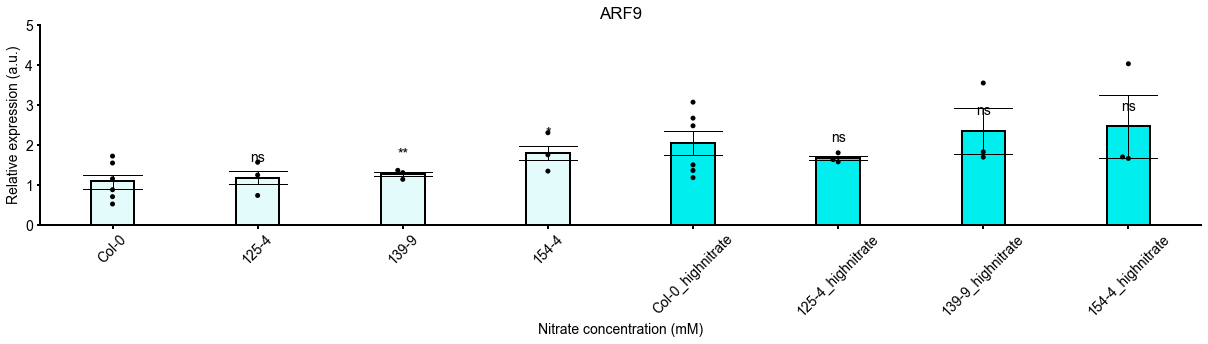

In [149]:
if __name__ == "__main__":
    main()

In [ ]:
# #normality tests - kolmogorov smirnov test
# #returns test statistic, p-value
# for name1 in prom_names_plate1:
#     for name in names_plate1:
#         print(name1,'{}: {}'.format(name, stats.shapiro(luminescence_raw_df_plate1['nluc/fluc'][luminescence_raw_df_plate1.TF_added == name])))
